In [1]:
import pandas as pd
import numpy as np

rating_df = pd.read_csv("../data/raw/ml-100k/u.data", sep="\t", index_col=False, names=["userID", "itemID", "rating"])
rating_df.head(10)

C:\Users\freid\AppData\Local\Temp\ipykernel_44776\2200433025.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  rating_df = pd.read_csv("../data/raw/ml-100k/u.data", sep="\t", index_col=False, names=["userID", "itemID", "rating"])


,userID,itemID,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4
6,115,265,2
7,253,465,5
8,305,451,3
9,6,86,3


In [2]:
# From u.info
# 943 users
# 1682 items
# 100000 ratings
min_num_of_items_that_user_rate = 18

user_items_list = []  # Will contains the list of items that user rate and ratings
for i in range(943):
    user_items_list.append([])

for index, r in rating_df.iterrows():
    user_items_list[r["userID"] - 1].append((r["rating"], r["itemID"] - 1))
print(user_items_list[:5])

[[(4, 60), (3, 188), (4, 32), (4, 159), (4, 19), (5, 201), (5, 170), (4, 264), (2, 154), (3, 116), (4, 46), (4, 221), (5, 252), (5, 112), (4, 226), (3, 16), (4, 89), (5, 63), (3, 91), (5, 227), (1, 265), (4, 120), (5, 113), (4, 131), (1, 73), (4, 133), (4, 97), (4, 185), (5, 220), (4, 83), (3, 30), (3, 69), (5, 59), (5, 176), (2, 26), (1, 259), (2, 144), (5, 173), (3, 158), (5, 81), (4, 55), (3, 271), (4, 79), (4, 228), (1, 139), (2, 224), (5, 234), (1, 119), (3, 124), (3, 214), (5, 5), (1, 103), (3, 48), (4, 205), (4, 75), (4, 71), (4, 184), (5, 95), (2, 212), (2, 232), (5, 257), (5, 80), (1, 77), (4, 211), (1, 142), (4, 150), (4, 50), (5, 174), (4, 106), (3, 217), (4, 208), (1, 258), (5, 107), (3, 261), (5, 11), (5, 13), (3, 96), (5, 43), (3, 52), (4, 162), (4, 209), (4, 183), (4, 156), (3, 200), (5, 149), (5, 182), (4, 247), (5, 207), (4, 127), (5, 241), (2, 147), (1, 111), (4, 192), (2, 263), (1, 218), (3, 231), (4, 235), (2, 251), (3, 199), (3, 179), (4, 249), (3, 84), (5, 90), (3

In [3]:
import random

frac = 0.85
splt_idx = int(frac * len(user_items_list))
train_data = user_items_list[:splt_idx]
y_test = user_items_list[splt_idx:]
X_test = []
for items_rating in y_test:
    X_test.append(random.choices(items_rating, k=min_num_of_items_that_user_rate))

In [4]:
from sklearn.neighbors import NearestNeighbors

class ItemToItemCollaborativeFiltering:
    def __init__(self, n_items, n_users, n_neighbors=5):
        self.n_users = n_users
        self.n_items = n_items
        self.n_neighbors = n_neighbors
        self.KNN = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
        
    @staticmethod
    def mean(lst):
        if len(lst) == 0:
            return 0.
        return sum(lst) / len(lst)
    def fit(self, user_items_list):
        # usr_items_list should be in following format:
        # [
        # [(some_rating_of_user_0, some_item_idx_for_user_0), ...],
        # [(some_rating_of_user_1, some_item_idx_for_user_1), ...]
        # ]
        print("Main model preparation...")
        self.user_items_list = user_items_list  # Store list item rating for user
        self.item_users_list = []  # Store list user ratings for item
        for i in range(self.n_items):
            self.item_users_list.append([])

        for userID, items_ratings in enumerate(user_items_list):
            for rating, itemID in items_ratings:
                self.item_users_list[itemID].append((rating, userID))

        self.mtr = np.zeros((self.n_items, self.n_users), dtype=float)
        self.mu = 0
        self.n_ratings = 0
        for userID, itemRatings in enumerate(user_items_list):
            mean_rating = self.mean([i[0] for i in itemRatings])
            for rating, itemID in itemRatings:
                self.mu += rating
                self.n_ratings += 1
                self.mtr[itemID][userID] = rating - mean_rating

        self.mu /= self.n_ratings
        self.mean_items_rating = np.empty(self.n_items)
        for i in range(self.n_items):
            mean_item_i_rating = self.mean([p[0] for p in self.item_users_list[i]])
            self.mean_items_rating[i] = mean_item_i_rating
        self.KNN.fit(self.mtr)
        self.precalc_neighbors()

    def precalc_neighbors(self):
        print("Precalculating neighbors...")
        self.itemID_neighbors = []
        for itemID in range(self.n_items):
            distances, idxs = self.KNN.kneighbors([self.mtr[itemID]])
            item_distances = {}
            for i in range(self.n_neighbors):
                idx = idxs[0][i]
                distance = distances[0][i]
                item_distances[idx] = distance
            self.itemID_neighbors.append(item_distances)

    def predict_item_rating_using_bl_est(self, itemID, N, items_distances, items_ratings):
        new_mu = self.mu * self.n_ratings + sum(items_ratings.values())
        new_mu = new_mu / (self.n_ratings + len(items_ratings))
        user_mean_rating = self.mean(items_ratings.values())
        item_rating = items_ratings[itemID] if itemID in items_ratings else 0

        item_mean_rating = ((self.mean_items_rating[itemID] * len(self.item_users_list[itemID]) + item_rating) /
                            (len(self.item_users_list[itemID]) + 1))
        b_user_itemID = user_mean_rating + item_mean_rating - new_mu
        if not N:
            return b_user_itemID

        pred_user_rating_for_itemID = 0
        denominator = 0
        for cur_itemID in N:
            cur_item_mean_rating = self.mean_items_rating[cur_itemID] * len(self.item_users_list[cur_itemID]) + \
                                   items_ratings[cur_itemID]
            cur_item_mean_rating = cur_item_mean_rating / (len(self.item_users_list[cur_itemID]) + 1)
            b_user_cur_itemID = user_mean_rating + cur_item_mean_rating - new_mu

            pred_user_rating_for_itemID += items_distances[cur_itemID] * (items_ratings[cur_itemID] - b_user_cur_itemID)
            denominator += items_distances[cur_itemID]
        pred_user_rating_for_itemID /= denominator if denominator > 1e-10 else 1
        pred_user_rating_for_itemID += b_user_itemID
        return pred_user_rating_for_itemID


    def predict(self, userItems):
        # userItems should contain items that user already rated in the following format:
        # [(rating, item1), (rating, item2), ...]
        rating_prediction = np.empty(self.n_items)
        item_rating = {}
        for rating, itemID in userItems:
            item_rating[itemID] = rating

        for itemID in range(self.n_items):
            if itemID in item_rating:
                rating_prediction[itemID] = item_rating[itemID]
                continue
            idxs = self.itemID_neighbors[itemID].keys()
            item_distances = self.itemID_neighbors[itemID]
            # Items that given user rated and similar to item with "itemID" ID
            N = set(idxs) & set(item_rating.keys()) - {itemID}  
            rating_prediction[itemID] = self.predict_item_rating_using_bl_est(itemID, N, item_distances, item_rating)

        return rating_prediction


In [7]:
import math


def calc_avg_RMSE(X, y, model):
    avg_RMSE = 0
    for i, user_preference in enumerate(X):
        RMSE = 0
        pred = model.predict(user_preference)
        for r, itemID in y[i]:
            RMSE += (pred[itemID] - r) ** 2
        RMSE = math.sqrt(RMSE / len(y[i]))
        avg_RMSE += RMSE
    avg_RMSE /= len(X)
    return avg_RMSE

In [13]:
avg_RMSEs = []
nbs = [1, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1682]
for nb in nbs:
    model = ItemToItemCollaborativeFiltering(n_users=len(train_data), n_items=1682, n_neighbors=nb)
    model.fit(train_data)
    avg_RMSEs.append(calc_avg_RMSE(X_test, y_test, model))
avg_RMSEs

Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...
Main model preparation...
Precalculating neighbors...


[0.8152555062407779,
 0.8769759500997303,
 0.8685444965061021,
 0.8495764112627657,
 0.8294167173461628,
 0.8181086599399546,
 0.8089892746877569,
 0.8029462031024872,
 0.8000415650093622,
 0.7982065513055361,
 0.7979220330288933,
 0.7962436620899902,
 0.794694179864828,
 0.7907096884367927,
 0.7916502999326257,
 0.7942553338621278,
 0.7955064313167125,
 0.7971839446461831]

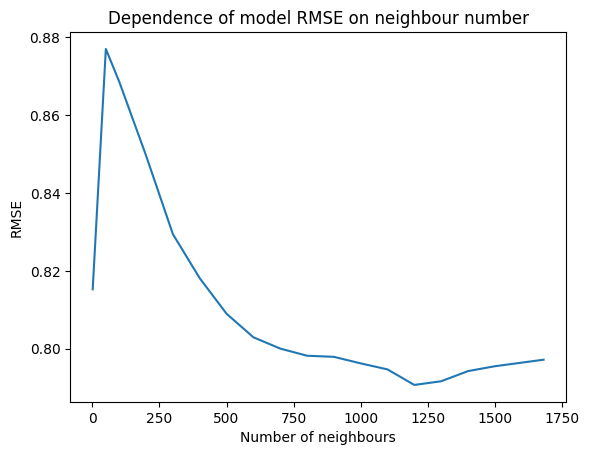

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(nbs, avg_RMSEs)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('RMSE')
ax.set_title('Dependence of model RMSE on neighbour number')
plt.show()